In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt
from math import sqrt, log
sns.set_style("darkgrid")
from tqdm.notebook import tqdm, trange

from sklearn.ensemble import RandomForestRegressor 
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split  
from pandas.plotting import scatter_matrix
from sklearn.preprocessing import StandardScaler  

In [3]:
prints = False

# Import des données

In [4]:
path = '../data/' 
hotels = pd.read_csv(path + '/features_hotels.csv')
data = pd.read_csv(path + 'data.csv')
data_test = pd.read_csv(path + 'test_set.csv')

In [5]:
# création de la colonne request_number dans le test set
data_test['request_number'] = 1
for avatar in np.unique(data_test['avatar_id']):
    data_test.loc[data_test['avatar_id'] == avatar, 'request_number'] = data_test['order_requests'].loc[data_test['avatar_id']== avatar] - min(data_test['order_requests'].loc[data_test['avatar_id']== avatar])+1

In [6]:
data_test

index  order_requests     city  date  language  mobile  avatar_id  \
0         0               1  vilnius    21  romanian       0          1   
1         1               1  vilnius    21  romanian       0          1   
2         2               1  vilnius    21  romanian       0          1   
3         3               1  vilnius    21  romanian       0          1   
4         4               1  vilnius    21  romanian       0          1   
...     ...             ...      ...   ...       ...     ...        ...   
6639   6639             843     rome     5     irish       0        794   
6640   6640             844   vienna     1     irish       1        794   
6641   6641             844   vienna     1     irish       1        794   
6642   6642             844   vienna     1     irish       1        794   
6643   6643             844   vienna     1     irish       1        794   

      hotel_id  stock  request_number  
0          161     46               1  
1          187     32               1  
2          279     12               1  
3          395     10               1  
4          488     42               1  
...        ...    ...             ...  
6639       987      1               3  
6640        26      1               4  
6641       263      0               4  
6642       456      0               4  
6643       699      0               4  

[6644 rows x 10 columns]

In [7]:
# ajout des caractéristiques des hotels
data = data.merge(hotels, on=['hotel_id','city'])
data_test = data_test.merge(hotels, on=['hotel_id','city'])
data_test = data_test.sort_values('index')    

In [8]:
# suppression de la requête de l'avatar_id 134 qui pose problème
# print(data.loc[data.avatar_id == 134])
data = data.drop(index = data.loc[data.avatar_id == 134].index)

# Approche naïve

Ici on génère des prix en utilisant les requêtes les plus proches.

In [9]:
# y_pred = []

# for i in tqdm(data_test.index) :
#     _, order, city, date, lang, mob, avatar, hotel, stock, req, group, brand, park, pool, child = data_test.iloc[i].values
#     data_tmp = data.loc[data.hotel_id == hotel]
#     delta_date = data_tmp.date.values - date
    
#     y_pred.append(data_tmp.iloc[np.argmin(delta_date)].price)

# Mise en forme des données

In [10]:
colQT = ['request_number', 'stock', 'date']
colBool = ['mobile', 'pool', 'parking']
colQL = ['city', 'language', 'group', 'brand', 'children_policy']

In [11]:
for col in ['city', 'language', 'avatar_id', 'hotel_id', 'group', 'brand','children_policy','mobile','parking','pool'] :
    data[col] = pd.Categorical(data[col],ordered=False)
    data_test[col] = pd.Categorical(data_test[col],ordered=False)

## Transformation des variables QL en QT

In [12]:
def additive_smoothing(x,alpha= 1.96):
    """ alpha = 1.96 borne à 95% pour la loi normale  """
    moy = (x+alpha).mean()
    d = x.max()-x.min()
    N = x.count()
    return N*moy/(N+alpha*d)

additive_smoothing.__name__ = 'additive_smoothing'

In [13]:
hotelId = False
if hotelId:
    colQL = ['hotel_id']
    colBool = ['mobile']

In [14]:
for i in colQL :
    df_tmp = data[[i,'price']].groupby(i).agg({'price':['mean','var',additive_smoothing]}).price
    df_tmp = df_tmp.add_suffix('_'+i)
    colQT+= list(df_tmp.columns.unique())
    data = data.join(df_tmp, on = i)
    data_test = data_test.join(df_tmp, on = i)


colQL = []

In [15]:
colQT += ['price']

# Analyse de stock

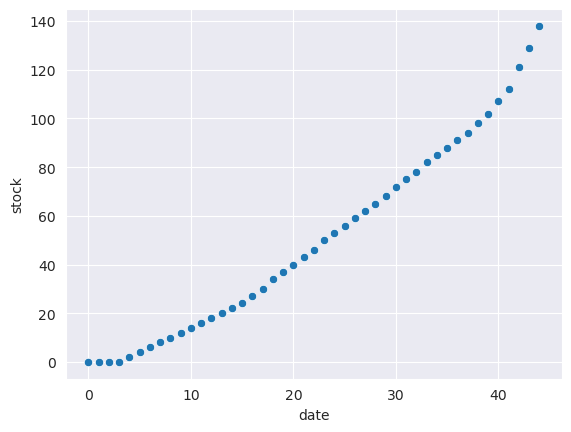

In [16]:
df_stock = data[['hotel_id','date','stock']].groupby(['hotel_id','date']).mean().reset_index()
test = df_stock.loc[df_stock.hotel_id == 500]

sns.scatterplot(data = test, x = 'date', y = 'stock')
plt.show()

# Exploration

In [17]:
if prints :
    plt.figure()
    sns.histplot(data['price'])
    plt.show()

## Unidimensionnelle

### QL

In [18]:
if prints :
    for col in colQL:
        fig, axes = plt.subplots(1, 2, figsize=(20, 3))
        sns.histplot(ax = axes[0], x = data[col])
        sns.histplot(ax = axes[1], x = data_test[col])
        axes[0].tick_params(labelrotation=45)
        axes[1].tick_params(labelrotation=45)
        axes[0].set_title('train set')
        axes[1].set_title('test set')
        plt.show()

### QT

In [19]:
if prints :
    for col in colQT[:-1]:
        fig, axes = plt.subplots(1, 2, figsize=(20, 3))
        sns.histplot(ax = axes[0], x = data[col])
        sns.histplot(ax = axes[1], x = data_test[col])
        axes[0].tick_params(labelrotation=45)
        axes[1].tick_params(labelrotation=45)
        axes[0].set_title('train set')
        axes[1].set_title('test set')
        plt.show()

## Bidimensionnelle

In [20]:
if prints :
    scatter_matrix(data[colQT], alpha=0.2, figsize=(10, 10), diagonal='kde')
    plt.tight_layout()
    plt.show()

In [21]:
if prints :
    scatter_matrix(data_test[colQT[:-1]], alpha=0.2, figsize=(10, 10), diagonal='kde')
    plt.tight_layout()
    plt.show()

# Transformations

In [22]:
transfo = False

In [23]:
if prints :
    plt.figure()
    sns.histplot(data['price'].map(lambda x: x**(1/3)))
    plt.show()

In [24]:
if transfo :
    data['SRprice'] = data['price'].map(lambda x: x**(1/3))
    colQT[-1] = 'SRprice'

# Préparation des datasets 

In [25]:
dummies = False

In [26]:
if dummies :
    dataDum = pd.get_dummies(data[colQL])
    dataDum_test = pd.get_dummies(data_test[colQL])
    if dataDum.shape[1] != dataDum_test.shape[1]:
        print('nombre de colonnes différent')
else:
    dataDum = None
    dataDum_test = None

In [27]:
dataQT = data[colQT[:-1]]
dataQT_test = data_test[colQT[:-1]]

In [28]:
dataBool = data[colBool]
dataBool_test = data_test[colBool]

In [29]:
df = pd.concat([dataDum,dataQT, dataBool],axis=1)
df_test = pd.concat([dataDum_test,dataQT_test, dataBool_test],axis=1)
df.head()

request_number  stock  date   mean_city     var_city  \
1               1     49    32  149.037867  4297.655923   
2               1     49    32  149.037867  4297.655923   
3               1      0     5  149.037867  4297.655923   
4               1     64    36  149.037867  4297.655923   
5               1     53    33  149.037867  4297.655923   

   additive_smoothing_city  mean_language  var_language  \
1               143.572342     163.048393   7736.373496   
2               143.572342     159.659293   7029.581497   
3               143.572342     166.795040   7254.519574   
4               143.572342     166.795040   7254.519574   
5               143.572342     164.477429   7345.704258   

   additive_smoothing_language  mean_group  ...  additive_smoothing_group  \
1                   159.330436  139.689729  ...                141.120474   
2                   159.340991  139.689729  ...                141.120474   
3                   163.852530  139.689729  ...                141.120474   
4                   163.852530  139.689729  ...                141.120474   
5                   156.393579  139.689729  ...                141.120474   

   mean_brand   var_brand  additive_smoothing_brand  mean_children_policy  \
1  128.490623  871.587405                129.568157            163.727362   
2  128.490623  871.587405                129.568157            163.727362   
3  128.490623  871.587405                129.568157            163.727362   
4  128.490623  871.587405                129.568157            163.727362   
5  128.490623  871.587405                129.568157            163.727362   

   var_children_policy  additive_smoothing_children_policy  mobile pool  \
1          7470.946181                           165.39358       1    0   
2          7470.946181                           165.39358       0    0   
3          7470.946181                           165.39358       1    0   
4          7470.946181                           165.39358       1    0   
5          7470.946181                           165.39358       0    0   

  parking  
1       1  
2       1  
3       1  
4       1  
5       1  

[5 rows x 21 columns]

In [30]:
# variable à expliquer
y = data[colQT[-1]]

# Séparation des données

In [31]:
submit = True

In [32]:
# séparation pour les tests et tunner les modèles
if submit :
    X_train = df
    X_test = df_test
    Y_train = y
    Y_test = None
else :
    X_train, X_test, Y_train, Y_test = train_test_split(df,y,test_size=.1,random_state=11) #25% pour le test_size

# Standardisation des données

In [33]:
stand = False

In [34]:
if stand :
    # standardisation des données
    scaler = StandardScaler()  
    scaler.fit(X_train)
    X_train_nonScale, X_test_nonScale = X_train.copy(), X_test.copy()
    X_train = scaler.transform(X_train)  
    # Meme transformation sur le test
    X_test = scaler.transform(X_test)

# Boosting

In [ ]:
# définition des paramètres
# boost = GradientBoostingRegressor()

GBR = GradientBoostingRegressor()

parameters = {'learning_rate': [0.01,0.02,0.03,0.04],
                  'subsample'    : [0.9, 0.5, 0.2, 0.1],
                  'n_estimators' : [100,500,1000, 1500],
                  'max_depth'    : [4,6,8,10]}

grid_GBR = GridSearchCV(estimator=GBR, param_grid = parameters, cv = 2, n_jobs=-1)

grid_GBR.fit(X_train, Y_train)

print(" Results from Grid Search " )
print("\n The best estimator across ALL searched params:\n",grid_GBR.best_estimator_)
print("\n The best score across ALL searched params:\n",grid_GBR.best_score_)
print("\n The best parameters across ALL searched params:\n",grid_GBR.best_params_)

In [ ]:
# apprentissage
rfFit = GBR.fit(X_train,Y_train)

In [ ]:
feature_importances = zip(X_train.columns,GBR.feature_importances_)
x = dict(feature_importances)
{k: v for k, v in sorted(x.items(), key=lambda item: -item[1])}

In [ ]:
if not submit:
# erreur de prédiction sur le test
    1-rfFit.score(X_test,Y_test)

In [ ]:
# prédiction
y_pred = rfFit.predict(X_test)
if not submit:
    print("RMSE =",np.sqrt(mean_squared_error(y_pred,Y_test)))
    print("R2 =",r2_score(Y_test,y_pred))

# Random Forest

In [ ]:
# définition des paramètres
forest = RandomForestRegressor(n_estimators=500,
                               max_depth=None,
                               min_samples_split=2, min_samples_leaf=1, 
                               max_features=1.0, max_leaf_nodes=None,
                               bootstrap=True, oob_score=True)
# apprentissage
rfFit = forest.fit(X_train,Y_train)
print(1-rfFit.oob_score_)

In [ ]:
param=[{"max_features":list(range(2,10,1))}]
rf= GridSearchCV(RandomForestRegressor(n_estimators=100),param,cv=5,n_jobs=-1)
rfOpt=rf.fit(X_train, Y_train)
# paramètre optimal
print("Meilleur score = %f, Meilleur paramètre = %s" % (1. - rfOpt.best_score_,rfOpt.best_params_))

In [ ]:
if not submit:
# erreur de prévision sur le test
    1-rfOpt.score(X_test,Y_test)

In [ ]:
# prévision
y_pred = rfOpt.predict(X_test)
if not submit :
    print("RMSE =",np.sqrt(mean_squared_error(y_pred,Y_test)))
    print("R2=",r2_score(Y_test,y_pred))

# Export submission

In [ ]:
print(y_pred)

In [ ]:
# save
newY = np.round(y_pred)
if transfo:
    newY = y_pred**3
if submit :
    sub = pd.DataFrame(newY)
    sub.to_csv(path + 'submit/boostQT_hotel_all.csv',index=True, header=['price'], index_label = 'index')

# A faire

> gridsearch sur alpha 

> ajouter une variable écart de temps

> fusionner children policy 1 et 2

> transfos sur le prix

> transfos sur autres variables QT

> soumission à faire:


1) RF 


2) tester hotelId = True 
